# Empowerment Week 2 Exercise: Explainability and Transparency

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">How to use this notebook</p>
    <div style="padding: 0 0 2px 10px;">

Simply read the text and **follow the instructions**.  
This notebook contains **code cells**, which can be modified and must be **executed** to see the result of their content.  
To execute a cell, select it and click on the play button (▶) in the tool  bar, or type `Shift + Enter` or `Ctr + Enter`.  

As the variables contained in a cell are stored in memory, the **order of execution** of the cells is important!  

Notebook by Maxime Lelièvre, Mattéo Berthet and the Responsible software TAs team (2024).<br/>
Except where otherwise noted, the content of this notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution International License</a> (CC BY 4.0 International).<br/>
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0;margin-top:10px;" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>

---
# Introduction
Welcome to this week exercise's session of Responsible Software!


Would you trust an algorithm that has a 95% accuracy but without knowing its inner workings? Would you trust it more if its accuracy was 98%? With more and more Machine Learning models being defined as "black-box" models, transparency and explainability have become a growing area of research in Machine Learning known as Explainable AI (XAI).

The objective of XAI is to bridge the gap between the human users and machine learning models by making the decision-making process of the model interpretable and transparent.

In this exercise, we will first explore the current challenges of transparency and explainability in Machine Learning. Then we will apply tools of XAI to discover its benefits as well as its shortcomings.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Learning Goals</p>
    <div style="padding: 0 0 2px 10px;">

**What will be covered :**
- **Part 1 :** Choose a ML model for a given application
- **Part 2 :** Attempt to explain the decisions of different models
- **Part 3 :** Review the limitations of XAI

**By the end of the session you will be able to:**
- ✅  Understand the challenges with transparency and explainability in Machine Learning.
- ✅  Apply some tools of XAI such as SHAP values.
- ✅  Understand the limitations of current XAI approches.

</div></div>

In [1]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

import shap
shap.initjs() # for creating interactive plots later on

# delete warning
import warnings
warnings.filterwarnings('ignore')

from res.utils import *

import otter
test = otter.Notebook()

# Part 1: Choosing the best ML model

You are working as a Machine Learning engineer/risk analyst in a big public bank. Your team is in charge of designing tools that help the bank take the best decision for loan applications. Following the exponential growth of AI, your team has been designing some Machine Learning models for a couple of years to classify loan applicants. After a lot of research and testing, the Machine Learning team found two promising models. Your manager is asking you to run a comprehensive evaluation to decide **which model the bank should deploy in real life**. 

The bank provides you with a large dataset to run your experiment. The dataset consists of demographic features from more than 25 000 individuals and includes a label mentioning whether they  obtained a loan from the bank or not.

*Note: the original dataset used in this notebook is the [US Census dataset](https://archive.ics.uci.edu/dataset/2/adult) that we have modified for the purpose of the story.*

Let's first explore the dataset!

## 1.1 Load and explore the dataset

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to load the dataset and see its first rows.

**Note:** The labels are in the last column of the dataframe (`Loan granted`).


</div></div>

In [2]:
data = load_dataset_eda()
data.head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
5  37.0            Private           14.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
5     Exec-managerial            Wife   White   Female           0.0   

   Capital Loss  Hours per week  Loan granted  
0           0.0            40.0         False  
1           0.0            13.0         False  
2           0.0            40.0         False  
3           0.0            40.0         False  
5           0.0            40.0         False

Here is a brief description of the columns in the dataset:
| features | description | value range
|----------|----------|--------|
| Age  |  age of the person in years |[17, 90]  |
| Workclass  | industry sector of employment | Private, Self-emp-not-inc,Self-emp-inc, Federal-gov,<br>Local-gov, State-gov, Without-pay, Never-worked  |
| Education-Num   | highest level of education  achieved, represented by a numerical code <br>(/!\ it does not correspond to years of education) | [1, 16]  |
| Marital Status   | marital status | Married-civ-spouse (civilian spouse), Divorced, Never-married, Separated,<br>Widowed, Married-spouse-absent, Married-AF-spouse (Armed Forces spouse) |
| Occupation   | category of occupation | Tech-support, Craft-repair, Other-service, Sales,<br>Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct,<br>Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv,<br>Protective-serv, Armed-Forces |
| Relationship   | relationship status (somewhat redundant with marital status) | Wife, Own-child, Husband, Not-in-family,<br>Other-relative, Unmarried |
| Race   |  race category | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
| Sex   | biological sex | Female, Male |
| Capital Gain   | capital gain in the previous year | [0.0, 99999.0] |
| Capital Loss   | capital loss in the previous year | [0.0, 4356.0] |
| Hours per week   | number of working hours per week | [1, 99] |
| Loan granted   | loan obtained or not by the person (label that the model learns to predict) | True, False |


<!--
Sources:
https://cdeiuk.github.io/bias-mitigation/finance/
https://archive.ics.uci.edu/dataset/2/adult
https://inria.github.io/scikit-learn-mooc/python_scripts/01_tabular_data_exploration.html
Preschool
1st-4th
5th-6th
7th-8th
9th
10th, 
11th, 
12th, 
HS-grad, 
Some-college, 
Assoc-voc, 
Assoc-acdm, 
Bachelors, 
Masters, 
Prof-school, 
Doctorate, 
-->

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to display graphs showing the distribution of the values in the dataset.

Note that we have not included all columns, feel free to explore by changing the code below. 
</div></div>

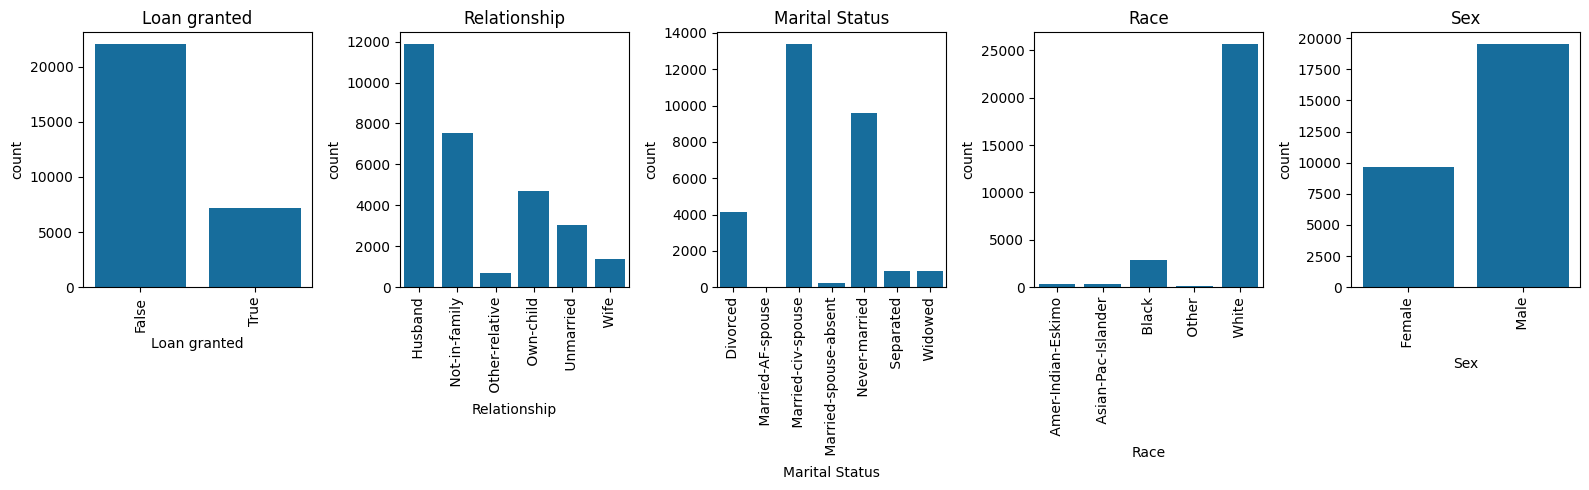

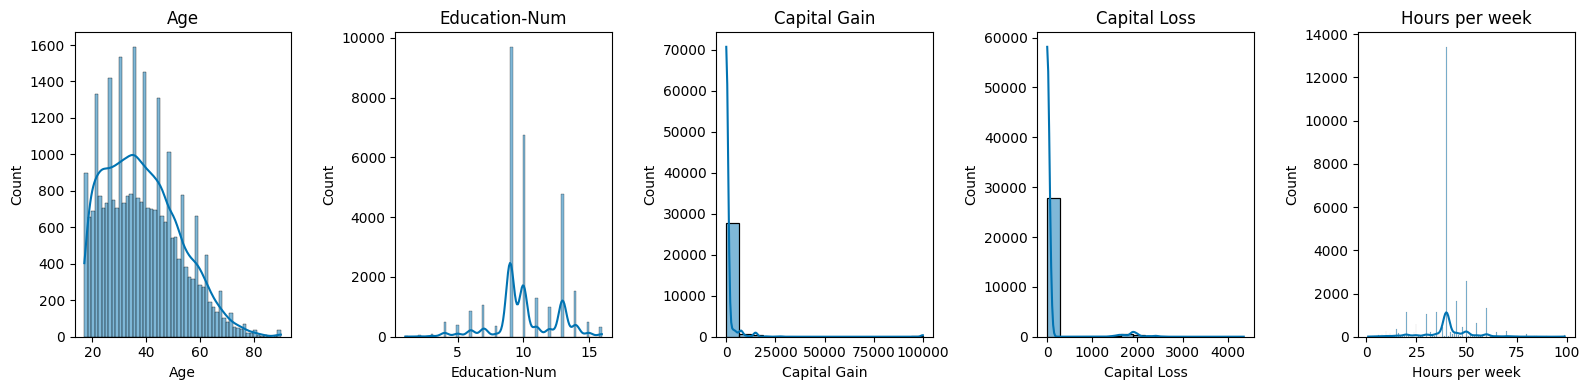

In [3]:
categorical_features =  ['Loan granted', 'Relationship', 'Marital Status', 'Race', 'Sex',]
numerical_features = ['Age', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']

# plot countplots for some categorical features
fig, axs = plt.subplots(1, len(categorical_features), figsize = (16,5))
for i, col in enumerate(categorical_features):
    sns.countplot(data = data, x = col, ax = axs[i])
    axs[i].set_title(col)
    axs[i].tick_params(axis = 'x', rotation = 90)
plt.tight_layout()
plt.show()

# plot histograms for numerical features
fig, axs = plt.subplots(1, len(numerical_features), figsize = (16,4))
for i, col in enumerate(numerical_features):
    sns.histplot(data[col], ax = axs[i], kde = True)
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time!</p>
    <div style="padding: 0 0 2px 10px;">

Analyze the graphs above to answer the following questions. 

Are loans most frequently granted or refused?

In the categorical features, what is the most frequent:
- Relationship category?
- Marital status?
- Race?
- Sex?

In the numerical features, what is the most frequent value for:
- Age?
- Education level?
- Capital gained in the previous year?
- Capital lost in the previous year?
        
</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">
        
- Loans are almost 4 times more often refused than granted.
- The most frequent relationship category is "Husband".
- The most frequent marital status is "Married-civ-spouse".
- The most frequent "race" is "White".
- The most frequent sex is "Male".
- The most frequent age is around 36 years old.
- The most frequent education level is 9 (corresponding to a category).
- The most frequent capital gained in the previous year is 0.
- The most frequent capital lost in the previous year is 0.

</div></div>

## 1.2 Train two classification models


You goal is to predict wether the applicant will be able to pay back the loan or not. You have all features and the label that your model should predict which is `Loan granted` which can either be `False` or `True`. If your model predicts accurately the label from the dataset, then the bank could use it on new applicants.

The two promising models that your team identified are: 
- a **Logistic Regression classifier (LR)**: this is a statistical model based on a mathematical function called the logistic function (to refresh your memory you can review quickly [the introduction to LR we have seen in the Fairness 2 module](../Notebook-4-Fairness-2/Intro_To_LR.ipynb)).
- a **Multi-Layer Perceptron (MLP)** with ReLU activation: this is a deep learning model that is composed of several layers of artificial neural networks, which cannot be easily represented by an equivalent mathematical function.

Both models have different complexity and interpretability capacities.

<div style="border-left: 6px solid rgba(128, 0, 128, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(128, 0, 128, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Note</p>
<div style="padding: 0 0 2px 10px;">
        
**Some definitions...** 
- **Complexity:** refers to the degree of intricacy or sophistication of a model, often determined by the number of parameters, layers, and operations it includes.
- **Interpretability:** refers to the ease with which humans can understand and make sense of the behavior, outputs, and internal mechanisms of a system or model, often through visualizations or intuitive explanations.

</div></div>

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Based on your intuition at this point, which sentence do you think is correct?

- A logistic regression model has a lower complexity than a neural network and is usually less interpretable.
- A logistic regression model has a lower complexity than a neural network but is usually more interpretable.
- A logistic regression model has a higher complexity than a neural network but is usually less interpretable.
- A logistic regression model has a higher complexity than a neural network and is usually more interpretable.
  
</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">

A logistic regression model has a lower complexity than a neural network but is usually more interpretable.

Logistic Regression is a highly interpretable model because it can be represented by a mathematical function whose coefficients directly indicate the contribution of each feature to the predicted probability, making it easy to explain. In contrast, a Multi-Layer Perceptron (MLP) with ReLU activation is a nonlinear model with multiple hidden layers, whose learned weights and activations are harder to interpret due to their complexity and lack of a straightforward mapping to input features. While MLPs can capture more complex relationships in the data, they trade off explainability for predictive power.

</div></div>

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

We have preprocessed the data for you to have numerical values in each column in order to directly train the model.

Run the cell below to load the preprocessed dataset.

</div></div>

In [4]:
df = load_dataset_model()
df.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   
1  50.0          6           13.0               2           4             4   
2  38.0          4            9.0               0           6             0   
3  53.0          4            7.0               2           6             4   
5  37.0          4           14.0               2           4             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Loan granted  
0     4    1        2174.0           0.0            40.0         False  
1     4    1           0.0           0.0            13.0         False  
2     4    1           0.0           0.0            40.0         False  
3     2    1           0.0           0.0            40.0         False  
5     4    0           0.0           0.0            40.0         False

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cells below to create the train and test sets. You can see we did not keep the `Race`, `Sex` and `Age` columns for our features. This is a choice to try to avoid a potential bias in the models.

Remember that the `Loan granted` column is the label we want to predict.

</div></div>

In [5]:
features = ['Workclass', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Capital Gain', 'Capital Loss', 'Hours per week']
label = 'Loan granted'

X = df[features]
y = df[label].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Length of train set: {len(X_train)} samples')
print(f'Length of test set: {len(X_test)} samples')

df[features + [label]].head()

Length of train set: 23336 samples
Length of test set: 5834 samples


Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0          7           13.0               4           1             0   
1          6           13.0               2           4             4   
2          4            9.0               0           6             0   
3          4            7.0               2           6             4   
5          4           14.0               2           4             5   

   Capital Gain  Capital Loss  Hours per week  Loan granted  
0        2174.0           0.0            40.0         False  
1           0.0           0.0            13.0         False  
2           0.0           0.0            40.0         False  
3           0.0           0.0            40.0         False  
5           0.0           0.0            40.0         False

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to define and train our logistic regression model defined as `lr_model`.

</div></div>

In [6]:
# Logistic regression model, defined as "lr_model"
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Regarding the 2 code cells above, which affirmation is **not** correct?

- The dataset has been split into two sets: one for training and one for testing.
- The model has been initialized and trained on the whole dataset.
- The model has been initialized and trained on the train dataset.
- The features and the label have been first separated from the original dataset.

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">
        
The model has been initialized and trained on the whole dataset.

</div></div>

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cells below to create the neural network model, which is done in 3 steps: definition of the model (layers etc.), training and loading.

**Note:** You don't need to understand the details of the neural network model. We put it here for your curiosity.

</div></div>

In [7]:
import torch
import torch.nn as nn

# Define the neural network
class SmallMLP(nn.Module):
    def __init__(self):
        super(SmallMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 256),
            nn.ReLU(),
            nn.Linear(256, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
    def predict_proba(self, x):
        # take a pandas dataframe as input and return raw predictions between 0 and 1
        x = torch.tensor(x, dtype=torch.float32)
        y = self.forward(x).detach().numpy()
        return y
    
    def predict_proba_row(self, x):
        # take a pandas dataframe as input and return raw predictions between 0 and 1
        x = torch.tensor(x.values, dtype=torch.float32)
        y = self.forward(x).squeeze().detach().numpy()
        return y
    
    def predict(self, x):
        # take a pandas dataframe as input and return binary predictions (True/False)
        x = x.values
        y = self.predict_proba(x)
        return y > 0.5

<div style="border-left: 6px solid rgba(128, 0, 128, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(128, 0, 128, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Note</p>
<div style="padding: 0 0 2px 10px;">

We have already trained the neural network model for you.   
Here is the training code for your curiosity but please don't run the cell below as training such a model requires relatively heavy computation, re-doing it would be unecessary and would have avoidable environmental impacts.

</div></div>

In [8]:
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler


# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# # Convert data to tensors
# X_train_tensor = torch.tensor(X.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y, dtype=torch.float32)

# # Split the data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

# # Move data to the selected device
# X_train, X_val = X_train.to(device), X_val.to(device)
# y_train, y_val = y_train.to(device), y_val.to(device)

# # Create a DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=32)

# # Instantiate the model
# model = SmallMLP().to(device)  # Move the model to the selected device

# # Define loss and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00005)

# # Training loop
# num_epochs = 100

# best_val_loss = float('inf')

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
        
#         outputs = model(batch_X).squeeze()
#         loss = criterion(outputs, batch_y)
        
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_val).squeeze()
#         val_loss = criterion(val_outputs, y_val)
#         val_preds = (val_outputs > 0.5).float()
#         accuracy = (val_preds == y_val).float().mean()
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 'small_mlp_dict.pth')
#             print(f"Model saved at epoch {epoch+1}")
    
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item():.4f}")


In [9]:
# Load the model
mlp_model = SmallMLP()
mlp_model.load_state_dict(torch.load('models/small_mlp.pth', map_location=torch.device('cpu')))
mlp_model.eval()

SmallMLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

## 1.3 Which has the best accuracy?
Now that both models are trained, we can evaluate their performance on the **test set**. Remember that the features are in `X_test`, and the ground truth is in `y_test`. 

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

The cell below generates the predictions from the models for the test set and stores the results in `y_lr` and `y_mlp`.

Complete the code to calculate the accuracy for both models.

**Hint**: See the method [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) from `sklearn.metrics` (and remember that our ground truth is in `y_test`).

</div></div>

In [10]:
from sklearn.metrics import accuracy_score

# Predictions
y_lr = lr_model.predict(X_test)
y_mlp = mlp_model.predict(X_test)

# Compute accuracy
### YOUR CODE HERE ###
lr_acc = accuracy_score(y_test, y_lr) # SOLUTION
mlp_acc = accuracy_score(y_test, y_mlp) # SOLUTION
#####################

print(f"Logistic regression model accuracy: {lr_acc*100:.2f}%")
print(f"Neural network model accuracy: {mlp_acc*100:.2f}%")

Logistic regression model accuracy: 79.41%
Neural network model accuracy: 83.94%


In [12]:
test.check("accuracy")

accuracy results: All test cases passed!

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Which model would you choose to deploy for the bank? Choose the option that best describes your reasoning.
- The MLP model because its accuracy is higher.
- The LR model because its accuracy is lower.
- The MLP model because a complex model will always perform better in reality than a less complex one.
- The LR model because it will be easier to undertand how it takes decisions, even though it is not the most accurate.
- None of them. I do not have enough information to decide.

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">
        
None of them. I do not have enough information to decide.

Here are some reasons:
- Interpretability vs. Complexity: In banking, transparency is crucial, so a simpler model might be preferable despite lower accuracy.
- Fairness and Bias: The model must be evaluated for potential biases to ensure fairness in decision-making.
- Real-world Performance: A complex model may overfit, leading to poor generalization in practice.
</div></div>

## 1.4 Is accuracy enough?

As an ethically trained engineer, you know that accuracy is not enough to evaluate the quality of a model.  
In particular, you remember from your Responsible Software course that you should always look at the different types of errors hidden behind the accuracy measure, in particular the False Positives and the False Negatives!

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Complete the code below to compute the confusion matrix for each model based on our test set.

**Hint:** See the method [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) from `sklearn.metrics` (and remember that our ground truth is in `y_test`).

</div></div>

In [13]:
from sklearn.metrics import confusion_matrix

### YOUR CODE HERE ###
cm_lr = confusion_matrix(y_test, y_lr) # SOLUTION
cm_mlp = confusion_matrix(y_test, y_mlp) # SOLUTION
######################

In [15]:
test.check("confusion_matrix")

confusion_matrix results: All test cases passed!

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to plot the confusion matrices.

</div></div>

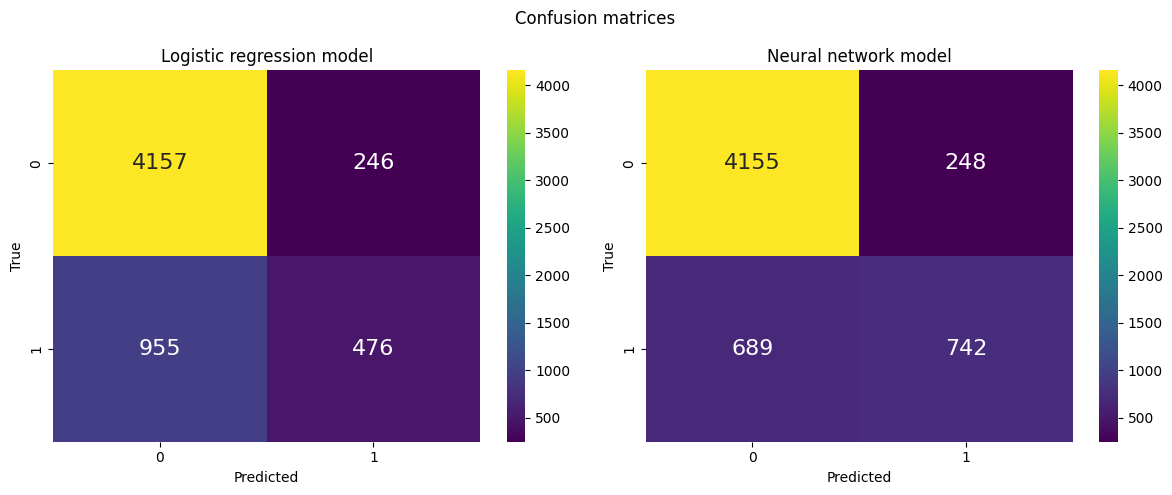

In [16]:
plot_confusion_matrices(cm_lr, cm_mlp)

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Which model would you choose to deploy for the bank? Choose the option that best describes your reasoning.

- The MLP model because it has less False Negatives, namely it will reject less loan applications that would have certainly been paid back and thus miss fewer opportunities for people who want to take a loan.
- The LR model because it has less False Positive, namely it will accept less loan applications that would not have paid back the bank and thus reduce the risks for the bank.
- None of them.

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">

The MLP model because it has less False Negatives, namely it will reject less loan applications that would have certainly been paid back and thus miss fewer opportunities for people who want to take a loan.

The false positives here mean a risk for the bank as they represent people who get a loan but will not pay it back, while the false negatives mean a lost opportunity for the bank as they represent people who do not get a loan even though they would actually pay it back. When looking at the magnitude of false negatives and false positives, the MLP model seems a better choice as the lower performance in false positives (248 - 246 = 2 more people not paying back the loan) would be higly compensated by the higher performance on false negatives (955 - 689 = 266 more customers).

</div></div>

# Part 2: Explaining model decisions

You proudly present your results to the managerial board of the bank, and recommend them to adopt the MLP model on the basis of your analysis above.  
However the CEO asks you: "That's very nice, but on which basis do your models make their decisions? Our bank has very strong ethical values and we are accountable to our clients, we must be able to explain how we decide to attribute loans or not.".

So you go back to your lab and you work on identifying how your models make decisions. You start first with the Logistic Regression model.

## 2.1 Feature Importance Analysis

The goal of Feature Important Analysis is to determine the relative importance of each feature in the decisions made by a machine learning model, as represented by a *feature importance score*. It provides valuable insights into the inner workings of the model and it is particularly useful for interpretability, as it allows us to explain the model's decisions to stakeholders and domain experts, and it can also be used for feature selection and engineering, helping to improve the model performance.

The way in which *feature importance score*s are determined depends on the type of model.  
For Logistic Regression it is very simple to obtain as the importance of each feature is represented almost directly by the coefficients of the model.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to see the feature importance analysis.

</div></div>

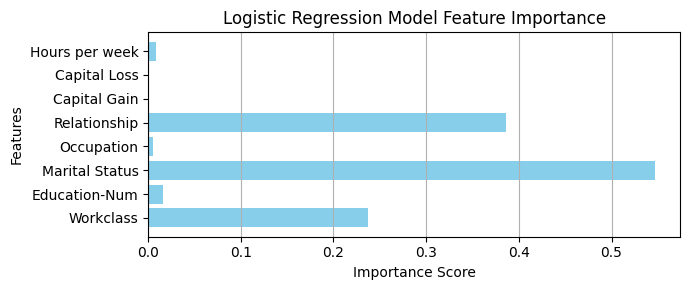

In [17]:
plot_feature_importance_analysis(lr_model, X_train)

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Does this feature importance analysis help you understand how the model makes its predictions?
</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">
        
We can see that the model relies heavily on the marital status and the workclass to make its predictions. This may seem a bit surprising as we would have expected the education level or the capital gain to be more important. This is a good example of how feature importance analysis can help us understand the model's decision-making process and identify potential biases or unexpected patterns in the data.

</div></div>

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

What could be the limitations of a feature importance analysis?

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">
        
While feature importance provides valuable insights into model behavior, it has limitations. These include:

1) **Univariate Analysis:** Feature importance scores are calculated individually for each feature, ignoring potential interactions between features.
2) **Model-Specific:** Feature importance is specific to the model used, and different models may assign different importance scores to the same features.
3) **Non-linear Relationships:** Feature importance may not capture non-linear relationships between features and the target variable.

</div></div>

## 2.2 Explainable AI (XAI) with SHAP

Now you would like to do the same with the MLP model. Unfortunately it is not as simple as with the LR model since the coefficients of the MLP model actually do not represent the importance of the different features (in addition there are way too many coefficients to allow any interpretation). This is a characteristic of neural network models. For this type of model you need to use a **post-hoc interpretability method** to be able to have information on how it makes decisions. 

There are several ways of doing this, but one well-recognized approach is called **SHAP** (SHapley Additive exPlanations). SHAP is a method that can be applied to all machine learning models, independently from their type. Described in an [original paper](https://arxiv.org/abs/1705.07874) in 2017, it is a method based on game theory concepts, particularly Shapley values, which assign each feature an importance score by considering its contribution to the difference between the model's predictions and a baseline prediction. This approach helps to evaluate the impact of individual features on model predictions, aiding in model debugging, feature engineering, and model selection.

### 2.2.1 Generating the SHAP values for our model

Overall, SHAP treats our model as a black box and uses it to make predictions using some input data, that it modifies to evaluate the importance of the different features and calculate the Shapley values.  
The [SHAP library](https://shap.readthedocs.io/en/latest/index.html) we're using allows us to create an object called an "explainer", that we can use to obtain so called "explanations" for decisions from our MLP model.  
In this notebook we use the explainer [`KernelExplainer()`](https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html).

<div style="border-left: 6px solid rgba(128, 0, 128, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(128, 0, 128, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Note</p>
<div style="padding: 0 0 2px 10px;">

We have already generated the SHAP values for you.   
Below is the code for your curiosity but please don't run the cell below as its requires relatively heavy computation, re-doing it would be unecessary and would have avoidable environmental impacts.

</div></div>

In [18]:
# explainer = shap.KernelExplainer(mlp_model.predict_proba, shap.kmeans(X_train, 100) )

# shap_values = explainer(X_test)

# with open('kernel_explainer.pkl', 'wb') as f:
#     pickle.dump(explainer, f)

# print('Explainer saved')

# with open('kernel_shap_values.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)
    
# print('SHAP values saved')

# shap_values.values = shap_values.values.squeeze()

# shap.plots.bar(shap_values)

### 2.2.2 Global explanation: feature importance

Now that we have the SHAP values, we can evaluate the importance of the different features in the decisions made by our model.  

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to compute display the feature importance for our MLP model. 

</div></div>

Explainer loaded
SHAP values loaded


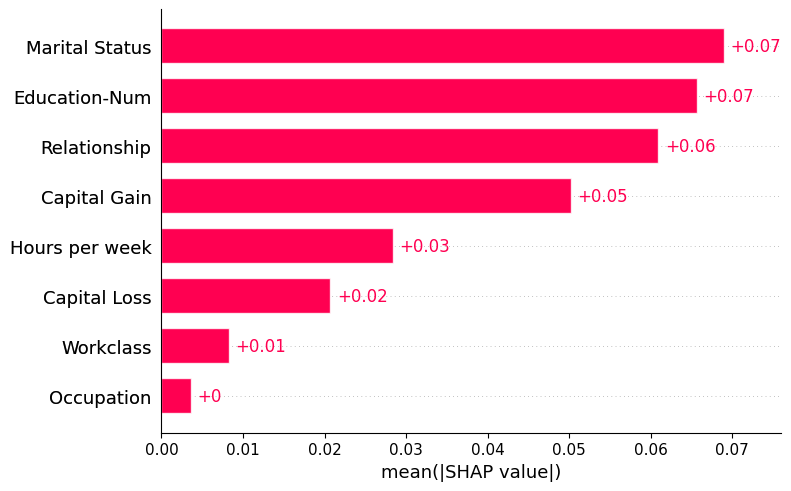

In [19]:
with open('res/kernel_explainer.pkl', 'rb') as f:
	explainer = pickle.load(f)
print('Explainer loaded') 

with open('res/kernel_shap_values.pkl', 'rb') as f:
	shap_values = pickle.load(f)
print('SHAP values loaded')

shap.plots.bar(shap_values)

**How to understand this plot?**

The plot above is a global bar plot. Here's a quick explanation of how to read it:

The plot has 3 main components:
- The Y-axis: represents individual features of the dataset (typically the columns of the dataframe passed as an argument).
- The X-axis: the mean absolute SHAP values. The SHAP values quantify the overall impact of each feature on the model's predictions across the entire dataset.
- The horizontal bars: represent each feature's average impact on the model's prediction. The length of the bar indicates the magnitude of the feature's impact, with longer bars signifying more influential features.

Reading the plot:

1. **Feature Importance**: The features are ordered from top to bottom based on their mean absolute SHAP value, with the most impactful feature at the top. This helps to quickly identify which features are most significant in the model.
2. **Magnitude of Impact**: Each bar's length on the X-axis reflects how much each feature contributes, on average, to the model's predictions. For instance, if the bar for "Marital Status" extends further than the bar for "Occupation", it means that "Marital Status" has a greater overall influence on the model's predictions than "Occupation."

This is called a **global explanation**, as it provides an overview of the model's behavior across the entire test dataset.


<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Does this global explanation help you understand how the model makes its predictions? Are the most important features the same for our MLP model as for our LR model?
</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">

This global explanation provides insights into the magnitude of each feature’s impact on the model’s predictions, averaged across the entire dataset. For instance, we observe that “Marital Status” and “Relationship” are significant features for both the MLP and LR models. However, the MLP model places considerable importance on the “Education-Num” feature, which is less influential for the LR model. This variation in feature importance highlights how different models can reflect distinct data patterns, even when trained on the same dataset.

</div></div>

### 2.2.3 Local explanation: focusing on one decision

The CEO of the bank is quite happy with the global explanation you have provided. But he wants to ensure that the bank is also able to explain individual decisions as this would be important for the clients.

You can also get SHAP values for single lines in the test dataset, so you show the CEO that your SHAP explanations include:
- The **prediction provided by the MLP model**: it is a probability between 0 and 1 that the customer will repay the loan (1 meaning the loan will be repaid).  
  You have defined a *cutoff value* at $0.5$ to decide when to *attribute the loan or not*.
- The cumulative **contribution of the different features** to the prediction given by the model, represented by their SHAP values provided by the explainer.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to compute the SHAP values for the applicant with idenfier `363`. 

</div></div>

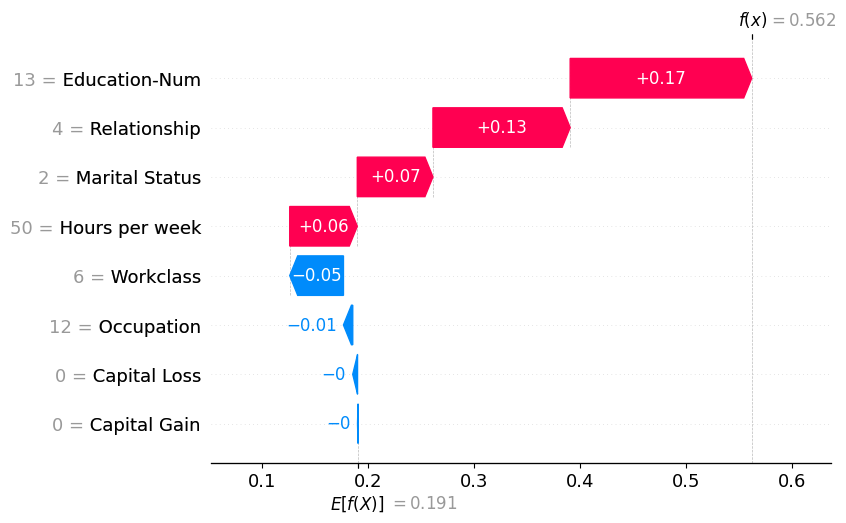

In [20]:
shap.plots.waterfall(shap_values[363], max_display=20)

**How to understand this plot?**

The plot above is a waterfall plot. Here's a quick explanation of how to read it:

The plot has 3 main components:
- The Y-axis: represents individual features of the dataset (typically the columns of the dataframe passed as an argument).
- The X-axis: the SHAP values. The SHAP values quantify the impact of each feature on the model's prediction.
- The horizontal bars: represent each feature's SHAP value and its impact (positive or negative). The length of the bar indicates the magnitude of the feature's impact.

Reading the plot:

1. **Prediction**: The value $f(x) = 0.562$ represented at the top of the graph is the output from our MLP model. If it is higher than the cutoff you have defined at 0.5, as is the case here, it means that the model predicts a loan should be granted to the applicant.

1. **Baseline Value**: The plot starts at a baseline value, which is the average prediction for the entire dataset ($E[f(X)]$). This is the starting point on the X-axis.
   We can see on the plot that $E[f(X)] = 0.191$, which is below the cutoff of 0.5 and means that on average the model does not grant the loan.
   
1. **Feature Contribution**: Each feature's contribution is added sequentially, showing how it increases or decreases the prediction from the baseline.  
    **Example**: 
      - A workclass of 6 decreased the probability to have the loan granted by 5% for this specific applicant.
      - An education level of 13 increased the probability to have the loan granted by 17% for this specific applicant.<br><br>

1. **Cumulative Effect**: As you move up the plot, each bar adds to the cumulative prediction, illustrating the combined effect of all feature contributions.  
    The bars that push the prediction to the right (positive impact) increase the likelihood of the positive class, while bars that push to the left (negative impact) decrease it.

The waterfall plot is a visualization for a single sample. It shows how the prediction for this specific instance is derived from the baseline by summing the contributions of each feature. For example, in this plot, the average sample in the test dataset is predicted to not be granted a loan (as we have seen that $E[f(X)] = 0.191 < 0.5$), but the chosen sample is predicted to be granted a loan since $f(x) = 0.562 > 0.5$.

This is called a **local explanation**, as it provides an explanation for a specific applicant of our dataset.


<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Based on the plot above, select the **incorrect** option:

- For the given sample, the feature Education-Num had a positive impact on the model's prediction.
- For the given sample, the feature Workclass did not have an impact on the model's prediction.
- For the given sample, the value of the feature Relationship made the prediction of the model be positive.
- For the given sample, the features Capital Loss and Capital Gain had the same impact on the model's prediction.

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">
        
For the given sample, the feature Workclass did not have an impact on the model's prediction.

It is false because we can see that having a value of 7 for Workclass made the SHAP value decrease by 0.05. Having a negative impact does not mean having no impact.

</div></div>

## 2.3 [Optional] Spreading trust among users

Your CEO is happy!
And he was right to ask you to do this since 2 weeks later a customer is coming at the bank to ask for explanations of why his application has been refused and what he could do for to maximize his chance for his next application. You are in charge of his case.

Your first step is to retrieve the information of this client from the database (here our test dataset).

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Display the information from the database for the customer with id `1113`.

**Note:** Consider that your database is the test dataset `X_test`.

</div></div>

In [21]:
customer_id = 1113 # SOLUTION

# print the row of the customer while keeping the column names
X_test.iloc[[customer_id]].head() # SOLUTION

Workclass  Education-Num  Marital Status  Occupation  Relationship  \
21114          0           11.0               2           0             5   

       Capital Gain  Capital Loss  Hours per week  
21114           0.0           0.0            35.0

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to compute the SHAP values for the customer.

</div></div>

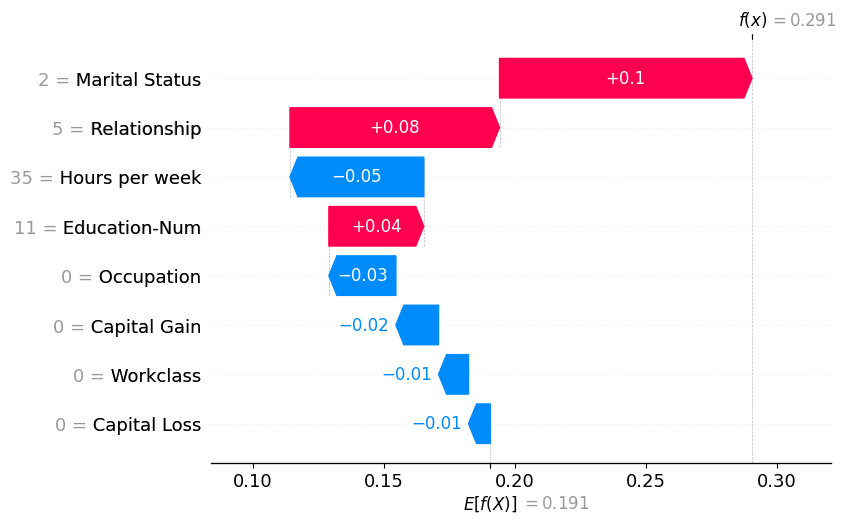

In [22]:
shap.plots.waterfall(shap_values[customer_id], max_display=20)

With the plot above you have:
- The output of the MLP model, which indicates that the loan has been refused for this customer as $f(x) = 0.291 < 0.5$
- A SHAP explanation for this customer which indicates the contributions of the different features.

But to be able to justify the bank decision to the customer, you want to understand how a **different situation** for the customer would have changed the decision from the model.  
One of your colleagues has designed a simulation where you can change the values of the different features and see how the output of the model would change (both the outcome and the explanation).

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

In the cell below:
- select a feature you want to change and put its name in the variable `feature_to_change`
- select the new value for the feature and put it in the variable `new_value`

Then run the cell to see the result on the output of the model and the corresponding explanation.  
Your goal is to determine at least **3 features to change** with their new values so that the customer **obtains their loan** (i.e. so that $f(x)$ gets above 0.5).

You can then complete the variables `first_solution`, `second_solution` and `third_solution` 2 cells below to see if your solution is correct.

</div></div>

  0%|          | 0/1 [00:00<?, ?it/s]

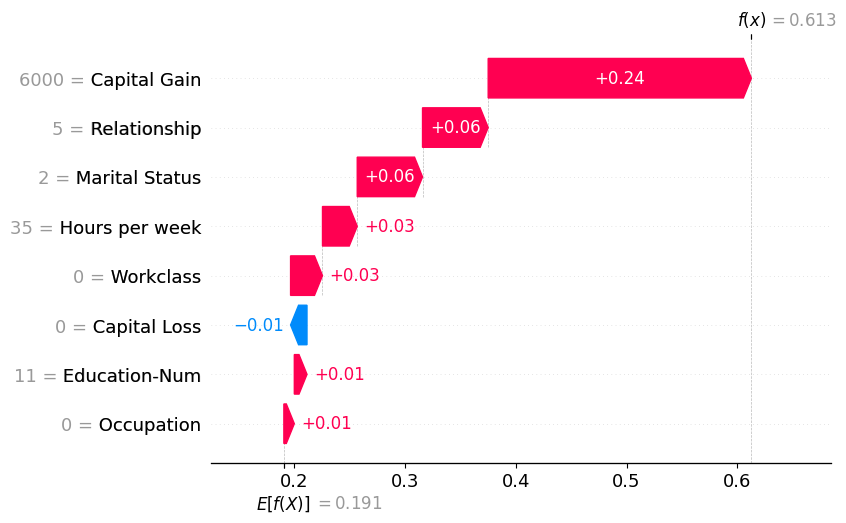

In [23]:
### PARAMETERS ###
feature_to_change = "Capital Gain" # SOLUTION
new_value = 6000 # SOLUTION
##################
simulation_customer(customer_id, mlp_model, shap_values, explainer, X_test, feature_to_change, new_value)

In [24]:
### Your results here ###
# solution = {Feature name": value}
first_solution = {"Capital Gain": 6000} # SOLUTION
second_solution = {"Hours per week": 60} # SOLUTION
third_solution = {"Education-Num": 15} # SOLUTION

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to test if your changes would have changed the prediction. If you get an error message, try to modify a typo in the feature name. Or be careful to the formating `solution = {"Feature name": value}`.

</div></div>

In [25]:
test_simulation(first_solution, second_solution, third_solution, customer_id, mlp_model, X_test)

The first solution is correct
The second solution is correct
The third solution is correct


## 2.4 Model debugging

While your CEO is happy, one of your colleague is actually worried: they are suspecting that the model is not working well for some specific cases.  
They ask you to help debug the model. To start your analysis, you decide to get a closer look at the SHAP values for the same customer as in the previous section.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the cell below to plot the SHAP values for the customer.

</div></div>

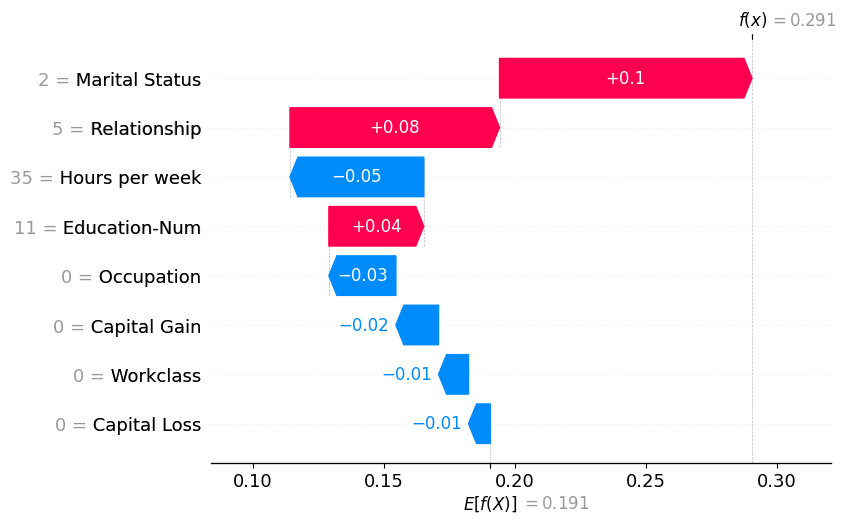

In [26]:
shap.plots.waterfall(shap_values[customer_id], max_display=20)

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

You choose to focus on the feature `Capital Loss` and try to first put `100` and see what happens.

</div></div>

  0%|          | 0/1 [00:00<?, ?it/s]

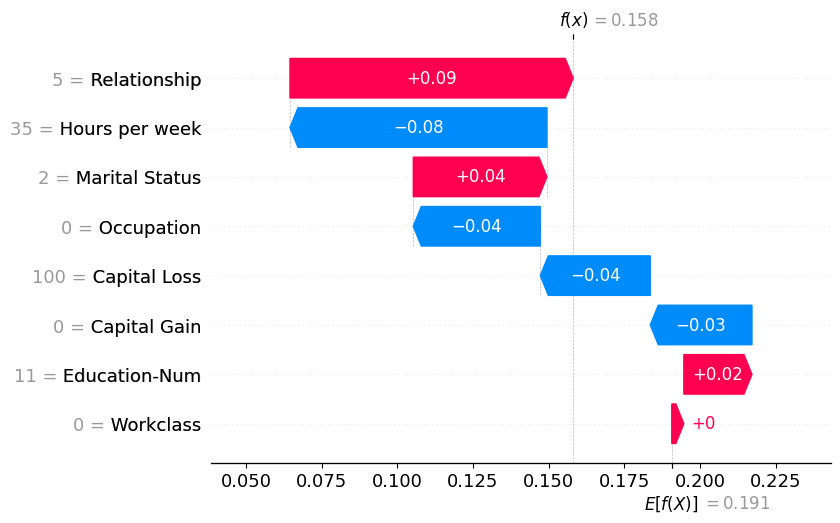

In [27]:
### PARAMETERS ###
feature_to_change = "Capital Loss" # SOLUTION
new_value = 100 # SOLUTION
##################
simulation_customer(customer_id, mlp_model, shap_values, explainer, X_test, feature_to_change, new_value)

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Does it make sense according to you?

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">

Yes it does. A positive capital loss has a negative impact on the model's prediction as the applicant is more likely to be in a difficult financial situation and less likely to pay back the loan. Here it decreases the probability of the loan to be granted by 4%.

</div></div>

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

You decide to investigate further by putting `1000` for the feature `Capital Loss`.

</div></div>

  0%|          | 0/1 [00:00<?, ?it/s]

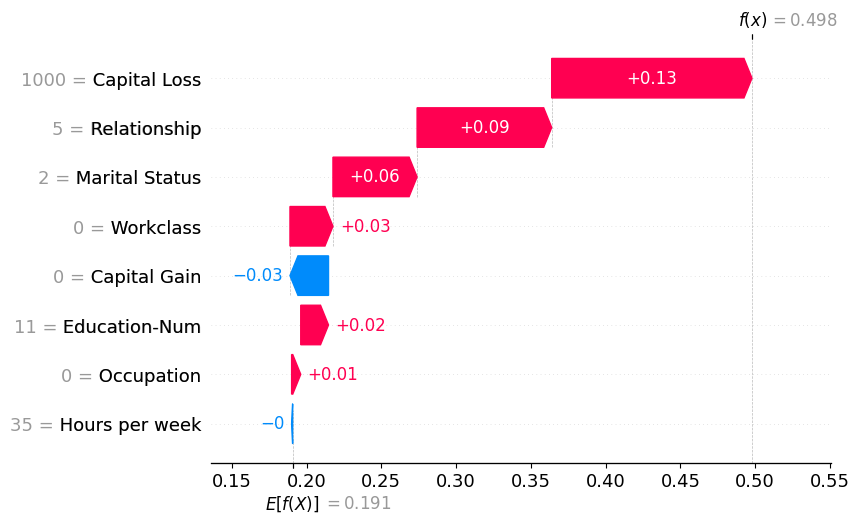

In [28]:
### PARAMETERS ###
feature_to_change = "Capital Loss" # SOLUTION
new_value = 1000 # SOLUTION
##################
simulation_customer(customer_id, mlp_model, shap_values, explainer, X_test, feature_to_change, new_value)

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

Does it make sense according to you?

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">

No it does not. A capital loss of 1000 should impact negatively the model's prediction as the applicant is more likely to be in a difficult financial situation and less likely to pay back the loan. However, here it increases the probability of the loan to be granted by 13%.

</div></div>

Well this is an interesting finding ! You can try even higher such as 3000 for `Capital Loss` and it would still be the same issue. 



<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Instructions</p>
    <div style="padding: 0 0 2px 10px;">

Run the folowing cell to display the distribution of the feature `Capital Loss` in the dataset. The y-axis represents the number of samples and the x-axis the value of the feature.

</div></div>

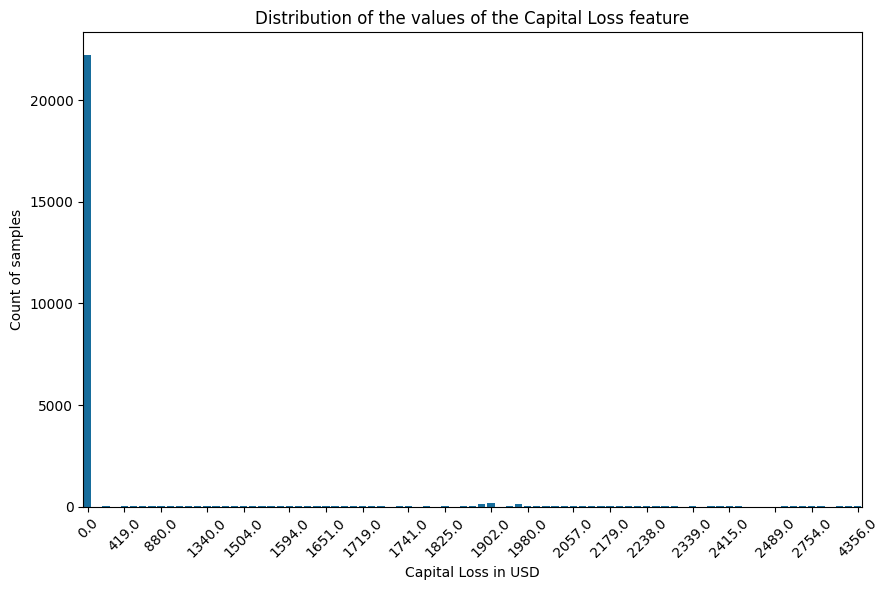

In [29]:
plot_capital_loss_distribution(X_train)

<div style="border-left: 6px solid rgba(255, 193, 7, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(255, 193, 7, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Reflection time !</p>
    <div style="padding: 0 0 2px 10px;">

How many samples have a `Capital Loss` greater than 0? What is the ratio of these samples compared to the total number of samples?

Where does the weird behavior of the model come from?

</div></div>

<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(40, 167, 69, 0.1); padding: 8px 0 8px 15px;"><strong>Feedback</strong> - Click on the "..." below <u>only once you have really tried to answer the question!</u></p>
</div>


<div style="border-left: 6px solid rgba(40, 167, 69, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <div style="padding: 0 0 2px 10px;">

All bars after a Capital Loss of 0 are extremely small compared to the beam at 0 wich is 20 000. This means that the model has not seen enough samples with a Capital Loss greater than 0 to learn how to predict them correctly. This is why it behaves weirdly when the Capital Loss is greater than 0.

A possible solution would be to:
- Resample the dataset to decrease the ratio of samples with a Capital Loss of 0.
- Use synthetic data generation techniques to generate more samples with a Capital Loss greater than 0.
- Use adversarial training to make the model more robust to these outliers.

</div></div>

---
# Part 3: Limitations of Explainable AI

Let's discuss more in depth the limitations of Explainable AI and its implications when using it in practice.


### 3.1 Post-Hoc Explainability

One of the main limitations when using tools such as **SHAP** (the library we used in the previous part) or **LIME** (another popular library for explainability) is that they provide **post-hoc explanations**. 

Post-hoc methods explain the predictions of a trained model without being an inherent part of the model itself. While useful, these explanations:
- May not perfectly align with the true internal logic of the model, especially for highly complex or non-linear architectures.
- Are vulnerable to instability, meaning small perturbations in the input data can lead to significant changes in the explanation.
- Are dependent on the chosen method's assumptions, which can lead to inconsistent or misleading insights across different tools.

Post-hoc explainability is therefore helpful for debugging and understanding models, but it should not be viewed as a definitive explanation of how the model works.


### 3.2 Towards Self-Explainable Neural Networks

Neural networks are increasingly used in practice due to their **high accuracy and scalability**. They are often chosen over traditional machine learning models that are interpretable by design, such as linear regression or decision trees.

However, as discussed in the first part of this notebook, neural networks are often considered **black boxes**, meaning their working is difficult to interpret. This opacity creates challenges in high-stakes applications where understanding model predictions is critical for trust, compliance, and debugging.

To address this, researchers are exploring **self-explainable neural networks**, which are designed to be interpretable by construction. One prominent example is the architecture proposed by **David Alvarez-Melis and Tommi Jaakkola** in their 2018 paper, "Towards Robust Interpretability with Self-Explaining Neural Networks" ([Read it here](https://dl.acm.org/doi/10.5555/3327757.3327875)). Their approach balances the trade-off between accuracy and interpretability by incorporating interpretable components directly into the model's architecture.

#### Challenges with Self-Explaining Neural Networks:
- The field is still **emerging and niche**, with fewer practical implementations compared to post-hoc methods.
- Models are often **harder to train** due to the added constraints for interpretability.
- Current self-explaining architectures can achieve **similar accuracy** to traditional neural networks but require more computational and design effort.

Despite these challenges, self-explainable neural networks represent a promising step towards making complex ML models interpretable.


### 3.3 What Should We Do in Practice?

When deciding how to approach interpretability in practice, you should consider the complexity of the task and the constraints of your project.

#### For Simpler Models:
- Use **interpretable models by design** such as:
  - Logistic regression
  - Decision trees
  - Generalized additive models (GAMs)
- These models offer transparency with little or no need for additional explanation tools.

#### For More Complex Models:
- If you require high accuracy and scalability and must use complex models (e.g., deep neural networks):
  - **Post-hoc explainability** is often the most practical choice unless you can train a self-explaining neural network.
  - To make the most of post-hoc methods:
    1. Use **multiple explainability tools** (e.g., SHAP, LIME) to cross-validate explanations and identify consistent patterns.
    2. Recognize the **limitations** of these methods and interpret results with caution.
    3. Use post-hoc explanations primarily to:
       - Debug the model.
       - Gain insights into its general behavior.
       - Understand feature importance or sensitivity.
    4. Avoid using these methods as standalone explanations for **stakeholders**, as their output may oversimplify or misrepresent the model's complexity.

#### Final Recommendation:
In critical applications where interpretability is paramount (e.g., healthcare, finance), prioritize **interpretable-by-design models** or **self-explaining architectures** where feasible. Reserve post-hoc methods for exploratory analysis or as supplementary tools.

# Congratulations! You have finished this notebook!